In [27]:
import os
import sys

os.environ["JAVA_HOME"] = "JDK 8"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, VectorAssembler, StringIndexer, IDF,HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator,TrainValidationSplit, ParamGridBuilder
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import abs
from pyspark.sql.functions import date_sub, current_date, lit
from pyspark.sql.functions import when
from pyspark.sql.functions import round
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [29]:
spark = SparkSession.builder.appName("credit_model").getOrCreate()

credit_model = "Credit_card.csv"

credit_df = spark.read.csv(credit_model, header=True, inferSchema=True)

credit_df.show()

+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
| Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|5008827|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|        -18772|       365243|           1|         0|    0|       0|           NULL|             2|
|5009744|     F|        

counting null values to determine drop and next manipulations for the based analyisis 

In [30]:
null_counts = credit_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in credit_df.columns])
null_counts.show()

+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|     0|     7|        0|            0|       0|           23|          0|        0|             0|           0|            22|            0|           0|         0|    0|       0|            488|             0|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+-----------

Handle missing values, particularly in the Type_Occupation column - considering an high number of null

In [31]:
#assigning NA to missing values

credit_df = credit_df.fillna({'Type_Occupation': 'NA'})
credit_df.show()

+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
| Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|5008827|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|        -18772|       365243|           1|         0|    0|       0|             NA|             2|
|5009744|     F|        

verfining maniplation in coloumn 

In [32]:
null_counts = credit_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in credit_df.columns])
null_counts.show()

+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|     0|     7|        0|            0|       0|           23|          0|        0|             0|           0|            22|            0|           0|         0|    0|       0|              0|             0|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+-----------

Handle missing values by dropping remaining null values of rows

In [33]:
credit_df = credit_df.dropna()
credit_df.show()

+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
| Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|5008827|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|        -18772|       365243|           1|         0|    0|       0|             NA|             2|
|5009744|     F|        

In [34]:
null_counts = credit_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in credit_df.columns])
null_counts.show()

+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+
|     0|     0|        0|            0|       0|            0|          0|        0|             0|           0|             0|            0|           0|         0|    0|       0|              0|             0|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+-----------

dropping unecessary colums for the analyisis  - Mobile_phone|Work_Phone|Phone|EMAIL_ID

In [35]:
credit_df = credit_df.drop("Ind_ID", "Mobile_phone", "Work_phone", "Phone", "EMAIL_ID")

credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|        -18772|       365243|             NA|             2|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        -13557|         -586|             NA|             2|
|     F|       

Normalise numerical features Birthday_count.

In [36]:
credit_df = credit_df.withColumn("Birthday_count", abs(col("Birthday_count"))) # transform negative values to positive
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|         18772|       365243|             NA|             2|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|         13557|         -586|             NA|             2|
|     F|       

consider Birthday_count as number of days

In [37]:
credit_df = credit_df.withColumn("Birthday_years", col("Birthday_count") / 365)
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|    Birthday_years|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|         18772|       365243|             NA|             2| 51.43013698630137|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|

DATE CONVERSION

In [38]:
# Define today's date
today_date = lit("2025-02-23")

# Calculate the past date based on Birthday_count
credit_df = credit_df.withColumn("Birthday_date", date_sub(today_date, col("Birthday_count")))
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|    Birthday_years|Birthday_date|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|         18772|       365243|             NA|             2| 51.43013698630137|   1973-10-02|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    

In [39]:
credit_df = credit_df.withColumn("Birthday_date", F.to_date(F.col("Birthday_date"), "dd-MM-yyyy"))
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|    Birthday_years|Birthday_date|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|         18772|       365243|             NA|             2| 51.43013698630137|   1973-10-02|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    

In [40]:
# Calculate age based on the 'Birthday_date'
credit_df = credit_df.withColumn("age", 
                                 F.when(F.col("Birthday_date").isNotNull(), 
                                        (F.datediff(F.current_date(), F.col("Birthday_date")) / 365).cast("int"))
                                 .otherwise(None))

credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+---+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|    Birthday_years|Birthday_date|age|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+---------------+--------------+------------------+-------------+---+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|         18772|       365243|             NA|             2| 51.43013698630137|   1973-10-02| 51|
|     F|        Y|            N|       0|     315000.0|Commercia

droppin unecessary columns 

In [41]:
credit_df = credit_df.drop("Birthday_count","Birthday_years","Birthday_date")
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Employed_days|Type_Occupation|Family_Members|age|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|       365243|             NA|             2| 51|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|         -586|             NA|             2| 37|
|     F|        Y|            N|       0|     315000.0|Commercial asso

Normalise numerical features Employed_days.

In [42]:
credit_df = credit_df.withColumn("Employed_days", when(col("Employed_days") > 0, "unemployed").otherwise(col("Employed_days"))) #give Employed_days "unemployed" value for positive numbers
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Employed_days|Type_Occupation|Family_Members|age|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|   unemployed|             NA|             2| 51|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|         -586|             NA|             2| 37|
|     F|        Y|            N|       0|     315000.0|Commercial asso

change negative employed_days to positive for an easier convertion to date - to apply the condition of Start date of employment. based a backward count from current day (0)

In [43]:
credit_df = credit_df.withColumn("Employed_days", when(col("Employed_days") == "unemployed", "unemployed").otherwise(abs(col("Employed_days"))))
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Employed_days|Type_Occupation|Family_Members|age|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|   unemployed|             NA|             2| 51|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        586.0|             NA|             2| 37|
|     F|        Y|            N|       0|     315000.0|Commercial asso

consider numbers values in Employed_days to be number of days based on 365 days a year

In [44]:
credit_df = credit_df.withColumn("Employed_years", when(col("Employed_days") == "unemployed", "unemployed").otherwise(col("Employed_days") / 365))
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Employed_days|Type_Occupation|Family_Members|age|    Employed_years|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+------------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|   unemployed|             NA|             2| 51|        unemployed|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        586.0|             NA|             2

TRANSFORM EMPLOYED_YEARS IN 1 DECIMAL NUMBER 

In [45]:
credit_df = credit_df.withColumn("Employed_years", when(col("Employed_years") == "unemployed", "unemployed").otherwise(round(col("Employed_years"), 1)))
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+--------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Employed_days|Type_Occupation|Family_Members|age|Employed_years|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+--------------+---+--------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|   unemployed|             NA|             2| 51|    unemployed|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        586.0|             NA|             2| 37|           

dropping Employed_days and keeping NEW Employed_years COLUM FOR ANALYSIS

In [46]:
credit_df = credit_df.drop("Employed_days")
credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+---+--------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+---+--------------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|             NA|             2| 51|    unemployed|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|             NA|             2| 37|           1.6|
|     F|        Y|            N|       0|     315000.0|Commercial

RAISE BIAS ISSUE ON MODEL BASED ON GENDER IF YOU CHOOSE TO KEEP IT IN ACCOUNT FOR THE MODEL

MOVING TO STEP 3 OF THE EXERCISE - 3 FEATURE ENGINEERING

SHOWING ALL TYPES OF HOUSING POSSIBLE IN THE DATASET

In [47]:
credit_df.select("Housing_type").distinct().show()

+-------------------+
|       Housing_type|
+-------------------+
|  House / apartment|
|Municipal apartment|
|    Co-op apartment|
|   Rented apartment|
|   Office apartment|
|       With parents|
+-------------------+



GIVING FR SCORE BASED ON CAR - PROPERTY AND HOUSING CONDITION

In [48]:
credit_df = credit_df.withColumn("FR_score", 
                                 
                                 F.when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "House / apartment"), 6)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Rented apartment"), 5)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Office apartment"), 4)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "With parents"), 3)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Co-op apartment"), 2)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Municipal apartment"), 1)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "House / apartment"), 4)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Rented apartment"), 3)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Office apartment"), 2)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "With parents"), 1)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "House / apartment"), 3)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Rented apartment"), 2)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Office apartment"), 1)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "With parents"), 0)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Co-op apartment"), 6)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Co-op apartment"), 4)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Co-op apartment"), 5)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Co-op apartment"), 1)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Municipal apartment"), 6)
                                 .when((F.col("Car_Owner") == "Y") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Municipal apartment"), 4)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "Y") & (F.col("Housing_type") == "Municipal apartment"), 5)
                                 .when((F.col("Car_Owner") == "N") & (F.col("Propert_Owner") == "N") & (F.col("Housing_type") == "Municipal apartment"), 1)
                                 .otherwise(1)
)

credit_df.show()



+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+---+--------------+--------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+---+--------------+--------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|             NA|             2| 51|    unemployed|       6|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|             NA|             2| 37|           1.6|       4|
|     F|        Y|  

In [49]:
credit_df.select("Marital_status").distinct().show()

+--------------------+
|      Marital_status|
+--------------------+
|           Separated|
|             Married|
|Single / not married|
|               Widow|
|      Civil marriage|
+--------------------+



In [50]:
credit_df = credit_df.withColumn(
    "Marital_status",
    F.when(
        F.col("Marital_status").isin("Married", "Civil marriage",) , "Y"
    ).when(
        F.col("Marital_status").isin("Separated", "Single / not married", "Widow"), "N"
    ).otherwise(F.col("Marital_status"))  # Keeps other values unchanged
)

credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Y|House / apartment|             NA|             2| 51|    unemployed|       6|
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Y|House / apartment|             NA|             2| 37|           1.6|       4|
|     F|        Y|            N|       0|     3150

In [51]:
credit_df.select("EDUCATION").distinct().show()

+--------------------+
|           EDUCATION|
+--------------------+
|     Academic degree|
|   Incomplete higher|
|Secondary / secon...|
|     Lower secondary|
|    Higher education|
+--------------------+



In [52]:
credit_df = credit_df.withColumn(
    "EDUCATION",
    F.when(
        F.col("EDUCATION").isin("Academic degree", "Higher education"), "High"
    ).when(
        F.col("EDUCATION").isin("Incomplete higher"), "Medium"
    ).when(
        F.col("EDUCATION").isin("Lower secondary", "Secondary / secondary special"), "Low"  
    )
)

credit_df.show()

+------+---------+-------------+--------+-------------+--------------------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|
+------+---------+-------------+--------+-------------+--------------------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|     M|        Y|            Y|       0|     180000.0|           Pensioner|     High|             Y|House / apartment|             NA|             2| 51|    unemployed|       6|
|     F|        Y|            N|       0|     315000.0|Commercial associate|     High|             Y|House / apartment|             NA|             2| 37|           1.6|       4|
|     F|        Y|            N|       0|     315000.0|Commercial associate|     High|             Y|Hous

Convert Type_Income into binary categories (example: "Stable" vs. "Unstable" income). 

In [53]:
credit_df = credit_df.withColumn(
    "Type_Income",
    F.when(
        F.col("Type_Income").isin("Commercial associate", "State servant", "Working"), "Stable"
    ).when(
        F.col("Type_Income").isin("Pensioner"), "Unstable"
    ).otherwise(F.col("Type_Income"))  # Keeps other values unchanged
)

credit_df.show()


+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+
|     M|        Y|            Y|       0|     180000.0|   Unstable|     High|             Y|House / apartment|             NA|             2| 51|    unemployed|       6|
|     F|        Y|            N|       0|     315000.0|     Stable|     High|             Y|House / apartment|             NA|             2| 37|           1.6|       4|
|     F|        Y|            N|       0|     315000.0|     Stable|     High|             Y|House / apartment|             NA|             2| 37|     

In [54]:
unemployed_count = credit_df.filter(col("Employed_years") == "unemployed").count()
print(f"Total number of unemployed: {unemployed_count}")

Total number of unemployed: 252


make type_income binary

Convert categorical variables (e.g., GENDER, Car_Owner) into numerical format using techniques like one-hot encoding.

In [55]:
categorical_features = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']

for column in categorical_features:
    credit_df.select(column).distinct().show()

+------+
|GENDER|
+------+
|     F|
|     M|
+------+

+---------+
|Car_Owner|
+---------+
|        Y|
|        N|
+---------+

+-------------+
|Propert_Owner|
+-------------+
|            Y|
|            N|
+-------------+

+-----------+
|Type_Income|
+-----------+
|   Unstable|
|     Stable|
+-----------+

+---------+
|EDUCATION|
+---------+
|     High|
|      Low|
|   Medium|
+---------+

+--------------+
|Marital_status|
+--------------+
|             Y|
|             N|
+--------------+

+-------------------+
|       Housing_type|
+-------------------+
|  House / apartment|
|Municipal apartment|
|    Co-op apartment|
|   Rented apartment|
|   Office apartment|
|       With parents|
+-------------------+

+--------------------+
|     Type_Occupation|
+--------------------+
|                  NA|
|            Managers|
|            HR staff|
|      Medicine staff|
|         Accountants|
|            Laborers|
|      Cleaning staff|
|Private service s...|
|             Drivers|
|    

CREATE NEW FEATURE INCOME FAMILY MEMBER

Create new features (e.g., Income per Family Member = Annual_income / Family_Members). 

In [56]:
credit_df = credit_df.withColumn(
    "Family_Members",
    when(col("Family_Members").isNull(), 1).otherwise(col("Family_Members"))  # Replace nulls with 1
)

credit_df = credit_df.withColumn(
    "Income_per_Family_Member",
    when(col("Family_Members") > 0, col("Annual_income") / col("Family_Members"))
    .otherwise(col("Annual_income"))  # If Family_Members is 0, just use Annual_income
)

In [57]:
credit_df.select("Income_per_Family_Member").show(5)

+------------------------+
|Income_per_Family_Member|
+------------------------+
|                 90000.0|
|                157500.0|
|                157500.0|
|                157500.0|
|                 90000.0|
+------------------------+
only showing top 5 rows



In [58]:
income_assembler = VectorAssembler(
    inputCols=["Income_per_Family_Member"], 
    outputCol="Income_per_Family_Member_vec"
)
credit_df = income_assembler.transform(credit_df)

# Verify
credit_df.select("Income_per_Family_Member", "Income_per_Family_Member_vec").show(5, truncate=False)

+------------------------+----------------------------+
|Income_per_Family_Member|Income_per_Family_Member_vec|
+------------------------+----------------------------+
|90000.0                 |[90000.0]                   |
|157500.0                |[157500.0]                  |
|157500.0                |[157500.0]                  |
|157500.0                |[157500.0]                  |
|90000.0                 |[90000.0]                   |
+------------------------+----------------------------+
only showing top 5 rows



In [59]:
credit_df.printSchema()

root
 |-- GENDER: string (nullable = true)
 |-- Car_Owner: string (nullable = true)
 |-- Propert_Owner: string (nullable = true)
 |-- CHILDREN: integer (nullable = true)
 |-- Annual_income: double (nullable = true)
 |-- Type_Income: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- Marital_status: string (nullable = true)
 |-- Housing_type: string (nullable = true)
 |-- Type_Occupation: string (nullable = false)
 |-- Family_Members: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- Employed_years: string (nullable = true)
 |-- FR_score: integer (nullable = false)
 |-- Income_per_Family_Member: double (nullable = true)
 |-- Income_per_Family_Member_vec: vector (nullable = true)



In [60]:
# Divide the subset of data into categorical and numerical
categorical_features = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']
numeric_features = ["CHILDREN", "Annual_income", "Family_Members", "age", "Employed_years", "FR_score", "Income_per_Family_Member_vec"]

ONE HOT ENCODER FOR ALL CAHTHEGORICAL VALUES 

In [61]:
stages = [] #FOR PIPLINE STAGES

for cat_feature in categorical_features:
    string_indexer = StringIndexer(inputCol = cat_feature, outputCol = f"{cat_feature}Index")
    encoder = OneHotEncoder(inputCol= f"{cat_feature}Index", outputCol= f"{cat_feature}Vec")
    stages += [string_indexer, encoder] #FIRST STRING INDEXER AND THEN HOT ENCODER LIKE APPENDING TO THE LIST SATGES []

#STRING INDEXER AND HOT ENCODER FOR CATEGORICAL FEATURES

In [62]:
all_features = numeric_features + [f"{cat}Vec" for cat in categorical_features] #ADD ALL CATEGORICAL FEATURES TO NUMERIC FEATURES VECTOR EXTENTION

assembler = VectorAssembler (inputCols = all_features, outputCol = "features" ) # PUTTING ALL FEATURES INTO ONE VECTOR DEFULT NAME ON OUTPUT COL IS FEATURES

stages += [assembler] #APPEND ASSEMBLER TO STAGES FOR PIPELINE

# PIPELINE FOR ALL STAGES TO CREATE A PIPELINE MODEL LIKE A CONTAINER FOR ALL STAGES PROCESS FLOW



Creating new features "Age" from Birthday_count and vectorizing the value

In [63]:
age_features = VectorAssembler(inputCols=["age"], outputCol="age_vec")

credit_df = age_features.transform(credit_df)

credit_df.show()

+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+------------------------+----------------------------+-------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|Income_per_Family_Member|Income_per_Family_Member_vec|age_vec|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+------------------------+----------------------------+-------+
|     M|        Y|            Y|       0|     180000.0|   Unstable|     High|             Y|House / apartment|             NA|             2| 51|    unemployed|       6|                 90000.0|                   [90000.0]| [51.0]|
|     F|        Y|            N|       0|     315000.0|     Stable|     

ABOVE DATA SET IS CLEAN AND NORMALIZED WITH HIGH QUALITY - NOW IS READY FOR A DEVELOPMENT INTO THE MODEL

WORKING ON NORMALIZING MORE FEATURE FOR A BETTER MODEL

In [64]:
credit_df = credit_df.withColumn("Employed_years", when(col("Employed_years") == "unemployed", 0).otherwise(col("Employed_years")))
credit_df.show()

+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+------------------------+----------------------------+-------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|Income_per_Family_Member|Income_per_Family_Member_vec|age_vec|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+------------------------+----------------------------+-------+
|     M|        Y|            Y|       0|     180000.0|   Unstable|     High|             Y|House / apartment|             NA|             2| 51|             0|       6|                 90000.0|                   [90000.0]| [51.0]|
|     F|        Y|            N|       0|     315000.0|     Stable|     

StringIndexer is used to convert categorical string values into numerical indices.
It takes inputCol (original categorical column) and creates outputCol (column with numeric index).
This is done for each column in categorical_columns, creating a list of indexers.

OneHotEncoder takes the indexed column (column+"_index") and converts it into a one-hot encoded vector.
This is useful for machine learning models that work better with numerical data.

A Pipeline is created with both StringIndexer and OneHotEncoder as stages.
fit(credit_df) learns from the dataset (e.g., assigns indices).
transform(credit_df) applies the transformations to the dataset.

 Convert categorical variables (e.g., GENDER, Car_Owner) into numerical format using techniques like one-hot encoding. 

In [65]:
feature_indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_features]

feature_encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_vec") for column in categorical_features]

pipeline = Pipeline(stages=feature_indexers + feature_encoders)

credit_df = pipeline.fit(credit_df).transform(credit_df)

credit_df.show()

+------+---------+-------------+--------+-------------+-----------+---------+--------------+-----------------+---------------+--------------+---+--------------+--------+------------------------+----------------------------+-------+------------+---------------+-------------------+-----------------+---------------+--------------------+------------------+---------------------+-------------+-------------+-----------------+---------------+-------------+------------------+----------------+-------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|age|Employed_years|FR_score|Income_per_Family_Member|Income_per_Family_Member_vec|age_vec|GENDER_index|Car_Owner_index|Propert_Owner_index|Type_Income_index|EDUCATION_index|Marital_status_index|Housing_type_index|Type_Occupation_index|   GENDER_vec|Car_Owner_vec|Propert_Owner_vec|Type_Income_vec|EDUCATION_vec|Marital_status_vec|Housing_type_vec|Typ

MODEL DEVELOPMENT - USE SPARK LINEAR REGRESSION OR RANDOM FOREST REGRESSION ALGORITHMS 

prepare the data for simple linear regression

In [66]:
df_SLR = credit_df.select("Income_per_Family_Member","Age", "Employed_years", "EDUCATION", "FR_score", "Type_Occupation", "Family_Members", "Annual_income")

df_SLR.show()

+------------------------+---+--------------+---------+--------+---------------+--------------+-------------+
|Income_per_Family_Member|Age|Employed_years|EDUCATION|FR_score|Type_Occupation|Family_Members|Annual_income|
+------------------------+---+--------------+---------+--------+---------------+--------------+-------------+
|                 90000.0| 51|             0|     High|       6|             NA|             2|     180000.0|
|                157500.0| 37|           1.6|     High|       4|             NA|             2|     315000.0|
|                157500.0| 37|           1.6|     High|       4|             NA|             2|     315000.0|
|                157500.0| 37|           1.6|     High|       4|             NA|             2|     315000.0|
|                 90000.0| 60|             0|      Low|       1|             NA|             2|     180000.0|
|                150000.0| 49|           1.9|      Low|       6|     Core staff|             3|     450000.0|
|         

In [67]:
feature_cols = ["Income_per_Family_Member", "Age","FR_score", "Family_Members"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_SLR = assembler.transform(df_SLR)

SPLIT DATA IN TRAINING AND TESTING SETS

In [68]:
train_data, test_data = df_SLR.randomSplit([0.8, 0.2], seed=42)


In [69]:
SLR = LinearRegression (featuresCol= "features", labelCol="Annual_income")


LR_MODEL = SLR.fit(train_data)

In [70]:
coef = LR_MODEL.coefficients
intercept = LR_MODEL.intercept

print("The coeffcient of this model is:", coef)
print("The intercept of this model is:", intercept)

The coeffcient of this model is: [1.4267269673197902,-52.51915087513331,4299.468945807435,60052.477716801644]
The intercept of this model is: -100231.70973324728


In [71]:
SLR_predictios = LR_MODEL.transform(test_data)

SLR_predictios.show()

+------------------------+---+--------------+---------+--------+--------------------+--------------+-------------+--------------------+------------------+
|Income_per_Family_Member|Age|Employed_years|EDUCATION|FR_score|     Type_Occupation|Family_Members|Annual_income|            features|        prediction|
+------------------------+---+--------------+---------+--------+--------------------+--------------+-------------+--------------------+------------------+
|                 13500.0| 27|           2.2|      Low|       3|         Sales staff|             4|      54000.0|[13500.0,27.0,3.0...| 170719.4049565702|
|                 14625.0| 39|          16.3|     High|       3|          Core staff|             4|      58500.0|[14625.0,39.0,3.0...|171694.24298430333|
|                 16875.0| 33|           1.6|      Low|       3|         Sales staff|             4|      67500.0|[16875.0,33.0,3.0...|175219.49356602365|
|                 19125.0| 40|           5.9|     High|       3|      

In [72]:
slr_predictions_pd = SLR_predictios.toPandas()
slr_predictions_pd.head()

,Income_per_Family_Member,Age,Employed_years,EDUCATION,FR_score,Type_Occupation,Family_Members,Annual_income,features,prediction
0,13500.0,27,2.2,Low,3,Sales staff,4,54000.0,"[13500.0, 27.0, 3.0, 4.0]",170719.404957
1,14625.0,39,16.3,High,3,Core staff,4,58500.0,"[14625.0, 39.0, 3.0, 4.0]",171694.242984
2,16875.0,33,1.6,Low,3,Sales staff,4,67500.0,"[16875.0, 33.0, 3.0, 4.0]",175219.493566
3,19125.0,40,5.9,High,3,NA,4,76500.0,"[19125.0, 40.0, 3.0, 4.0]",178061.995186
4,22500.0,31,4.6,Low,6,Cooking staff,3,67500.0,"[22500.0, 31.0, 6.0, 3.0]",136195.800180


TRAIN THE MODEL USING THE INPUT VARIABLES TO PREDICT ANNUAL_INCOME

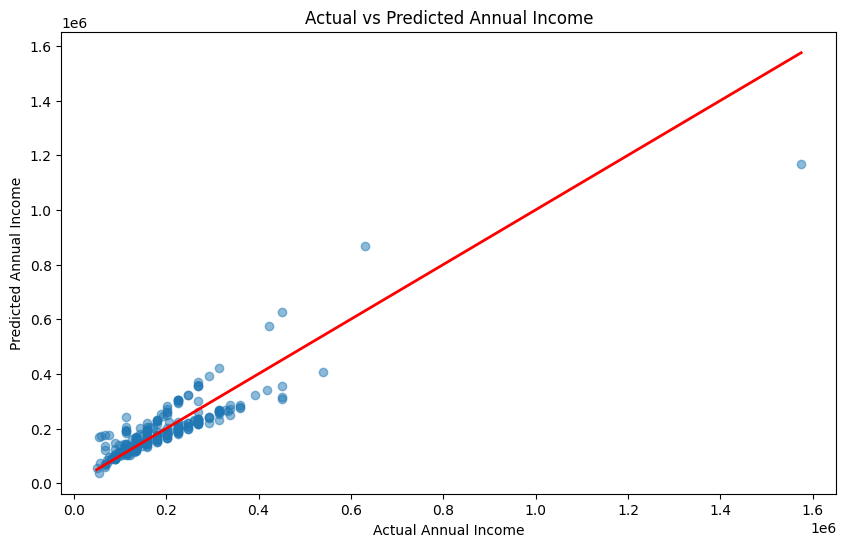

In [73]:
import matplotlib.pyplot as plt

slr_predictions_pd = SLR_predictios.select("Annual_income", "prediction").toPandas()


plt.figure(figsize=(10, 6))
plt.scatter(slr_predictions_pd["Annual_income"], slr_predictions_pd["prediction"], alpha=0.5)
plt.plot([slr_predictions_pd["Annual_income"].min(), slr_predictions_pd["Annual_income"].max()],
         [slr_predictions_pd["Annual_income"].min(), slr_predictions_pd["Annual_income"].max()],
         color='red', lw=2)
plt.xlabel("Actual Annual Income")
plt.ylabel("Predicted Annual Income")
plt.title("Actual vs Predicted Annual Income")
plt.show()

RANDOM FORREST REGRESSOR

In [74]:
rf = RandomForestRegressor(featuresCol="features", labelCol="Annual_income", numTrees=100, maxDepth=5)

RF_MODEL = rf.fit(train_data)

rf_predictions = RF_MODEL.transform(test_data) # Make predictions

rf_predictions.show()


+------------------------+---+--------------+---------+--------+--------------------+--------------+-------------+--------------------+------------------+
|Income_per_Family_Member|Age|Employed_years|EDUCATION|FR_score|     Type_Occupation|Family_Members|Annual_income|            features|        prediction|
+------------------------+---+--------------+---------+--------+--------------------+--------------+-------------+--------------------+------------------+
|                 13500.0| 27|           2.2|      Low|       3|         Sales staff|             4|      54000.0|[13500.0,27.0,3.0...|127289.31161044445|
|                 14625.0| 39|          16.3|     High|       3|          Core staff|             4|      58500.0|[14625.0,39.0,3.0...|128828.40608821352|
|                 16875.0| 33|           1.6|      Low|       3|         Sales staff|             4|      67500.0|[16875.0,33.0,3.0...|130799.42059085198|
|                 19125.0| 40|           5.9|     High|       3|      

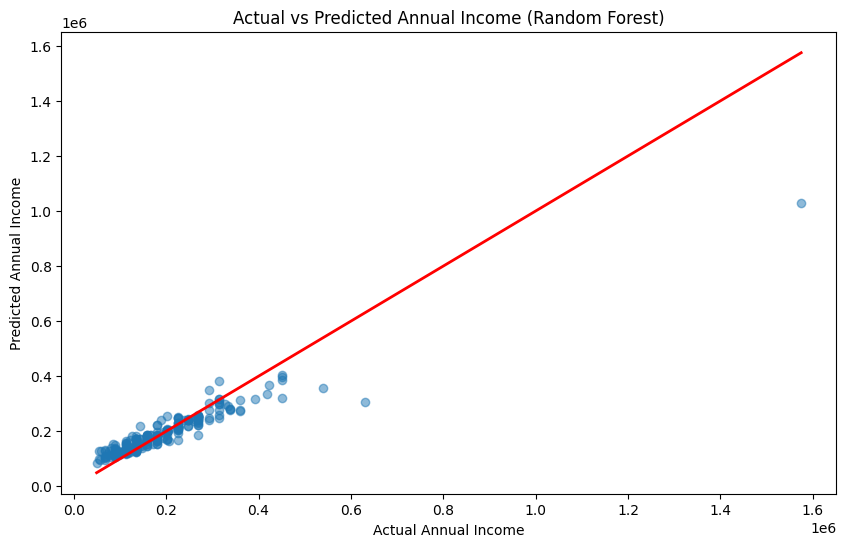

In [75]:
rf_predictions_pd = rf_predictions.select("Annual_income", "prediction").toPandas()

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(rf_predictions_pd["Annual_income"], rf_predictions_pd["prediction"], alpha=0.5)
plt.plot([rf_predictions_pd["Annual_income"].min(), rf_predictions_pd["Annual_income"].max()],
         [rf_predictions_pd["Annual_income"].min(), rf_predictions_pd["Annual_income"].max()],
         color='red', lw=2)
plt.xlabel("Actual Annual Income")
plt.ylabel("Predicted Annual Income")
plt.title("Actual vs Predicted Annual Income (Random Forest)")
plt.show()

EVALUATE THE MODEL

rrot mean squared to Simple linear regression

In [76]:
slr_evaluator = RegressionEvaluator(labelCol="Annual_income", predictionCol="prediction", metricName="rmse")

slr_rmse = slr_evaluator.evaluate(SLR_predictios)

print(f"Root Mean Squared Error (RMSE) on test data for Simple Linear Regression = {slr_rmse}")

Root Mean Squared Error (RMSE) on test data for Simple Linear Regression = 55527.11877933004


rrot mean squared to forest regression

In [77]:
evaluator = RegressionEvaluator(labelCol="Annual_income", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 51862.482396305306


# Evaluate the Random Forest model using R-squared


In [78]:
r2_evaluator = RegressionEvaluator(labelCol="Annual_income", predictionCol="prediction", metricName="r2")

r2 = r2_evaluator.evaluate(rf_predictions)

print(f"R-squared (R2) on test data = {r2}")

R-squared (R2) on test data = 0.82665069845662


# Evaluate the Simple Linear Regression model using R-squared


In [79]:
slr_r2_evaluator = RegressionEvaluator(labelCol="Annual_income", predictionCol="prediction", metricName="r2")

slr_r2 = slr_r2_evaluator.evaluate(SLR_predictios)

print(f"R-squared (R2) on test data for Simple Linear Regression = {slr_r2}")

R-squared (R2) on test data for Simple Linear Regression = 0.801287231709326


6. Hyperparameter Tuning:

In [80]:
paramGrid = ParamGridBuilder() \
    .addGrid(SLR.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(SLR.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Annual_income", predictionCol="prediction", metricName="rmse")

# Create the CrossValidator
crossval = CrossValidator(estimator=SLR,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 5-fold cross-validation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

# Make predictions on the test data
cv_predictions = cvModel.transform(test_data)

# Evaluate the model
cv_rmse = evaluator.evaluate(cv_predictions)
cv_r2 = evaluator.evaluate(cv_predictions, {evaluator.metricName: "r2"})

print(f"Cross-Validated Root Mean Squared Error (RMSE) on test data = {cv_rmse}")
print(f"Cross-Validated R-squared (R2) on test data = {cv_r2}")

Cross-Validated Root Mean Squared Error (RMSE) on test data = 55527.2040124841
Cross-Validated R-squared (R2) on test data = 0.8012866216676252
